In [1]:
# install the necessary modules
!pip install requests
!pip install pandas
!pip install numpy
!pip install beautifulsoup4

In [1]:
# import the necessary modules
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

# use requests to pull the data
url = (
    "https://www.worldometers.info/coronavirus/#countries"
)

r = requests.get(url)

# use beautifulsoup to parse the data
soup = BeautifulSoup(r.content, "html")

<!DOCTYPE html>
<!--[if IE 8]> <html lang="en" class="ie8"> <![endif]-->
<!--[if IE 9]> <html lang="en" class="ie9"> <![endif]-->
<!--[if !IE]><!-->
<html lang="en">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <title>
   COVID - Coronavirus Statistics - Worldometer
  </title>
  <meta content="Daily and weekly updated statistics tracking the number of COVID-19 cases, recovered, and deaths. Historical data with cumulative charts, graphs, and updates." name="description"/>
  <!-- Favicon -->
  <link href="/favicon/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/favicon/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
  <link href="/favicon/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
  <link href="/favicon/apple-icon-72x72.png" rel="apple-touch-icon" sizes="72x72"/>
  <link href="/favicon/apple-icon-76x
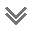

In [2]:
# look for the table we need with prettify
# suppressing output since hidding it made it still display in the .ipynb file
print(soup.prettify())

In [26]:
# grab the table data
table = soup.find('table', id='main_table_countries_today')


#get the column headers
headers = [header.text.strip() for header in table.find_all('th')]

#get the row information
table_body = table.find('tbody')
data_rows = table_body.find_all('tr')
countries_data = []
for row in data_rows:
    cols = row.find_all('td')
    cols_text = [ele.text.strip() for ele in cols]

    # Check if the first column is empty or not a number (assuming it should be a ranking number)
    if not cols_text[0].isdigit():
        # Shift the data to the right and insert 'X' or some placeholder in the first position
        cols_text.insert(0, 'X')

    # Ensure the row has the same number of elements as the headers
    if len(cols_text) == len(headers):
        countries_data.append(cols_text)


#the # column keeps getting country, other put into it so I removed that column
adjusted_headers = headers[1:]

# since I removed the first column, I have to remove it from each row
countries_data = [[col.text.strip() for col in row.find_all('td')[1:]] for row in data_rows]

#make the df and look at the first few rows
covid_df = pd.DataFrame(countries_data, columns=adjusted_headers)

covid_df.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/\n1M pop,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,North America,"128,997,336",,"1,652,633",,"124,719,053","+1,334","2,625,650","6,549",,,,,,North America,,,,,,
1,Asia,"220,810,861",+82,"1,551,534",+2,"204,530,282",+17,"14,729,045","15,143",,,,,,Asia,,,,,,
2,Europe,"250,790,529","+1,039","2,078,038",+2,"246,633,821","+3,506","2,078,670","5,649",,,,,,Europe,,,,,,
3,South America,"69,178,247",,"1,362,310",,"66,556,462",,"1,259,475","10,098",,,,,,South America,,,,,,
4,Oceania,"14,698,883",,"30,699",,"14,561,851",,"106,333",49,,,,,,Australia/Oceania,,,,,,


In [62]:
#from index 8 onwards is where all the individual country data starts. Otherwise it's
#summary data of regions and the world (North America, Asia, etc)
#covid_df

active = covid_df['ActiveCases'][8:]
#I need to remove the commas from ActiveCases so that I can convert to numeric
active = active.str.replace(',','')

#remove the N/A countries since we don't have data on them
# we shouldn't keep the rows in our data since it will artificially lower
# our average
active = active.replace('N/A', np.nan).dropna()

#convert everything to integers. There shouldn't be any partial covid cases or partial
#people
active = active.astype(int)
#since active is a panda series we can just use the mean() function
average_active = active.mean()

#print the results
print('The average active number of cases per country that we have data on is'
      , average_active)



The average active number of cases per country that we have data on is 35721.171428571426


In [73]:
#now to get the total population from the same datapoints so we can calculate
#the total proportion of the population that is currently infected
pop = covid_df['Population'][8:]

#I need to remove the commas from ActiveCases so that I can convert to numeric
pop = pop.str.replace(',','')

#Note that we are going to include the countries where their ActiveCases was N/A
# This artifically lowers our proportion
# I don't love this approach. If I were to take this analysis further I would
# estimate the activecases populations based on surrounding countries
# and fill in the N/A activecases to give us a better estimate

#we need to remove a few countries that have blank population columns
pop = pop.replace('',np.nan).dropna()

#convert to integer
pop = pop.astype(int)

#get the total population
population_total = pop.sum()

#get the percent infected
perc_infect = active.sum()/pop.sum()

#print the results
print('The percent of the population that is currently infected is ', perc_infect)

The percent of the population that is currently infected is  0.000944179641030728
